<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W2/ungraded_labs/C4_W2_Lab_3_deep_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Training a Deep Neural Network with Time Series Data

In this lab, you will build upon the previous exercise and add more dense layers to your network. You will also look at a technique to tune the model's learning rate to make the weights converge faster. This is a useful tip so you can avoid guessing the learning rate before training.

The initial steps will be identical to the previous lab so you can run the next cells until the `Build the Model` section. That's where the discussions begin.

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Utilities

In [8]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

## Generate the Synthetic Data

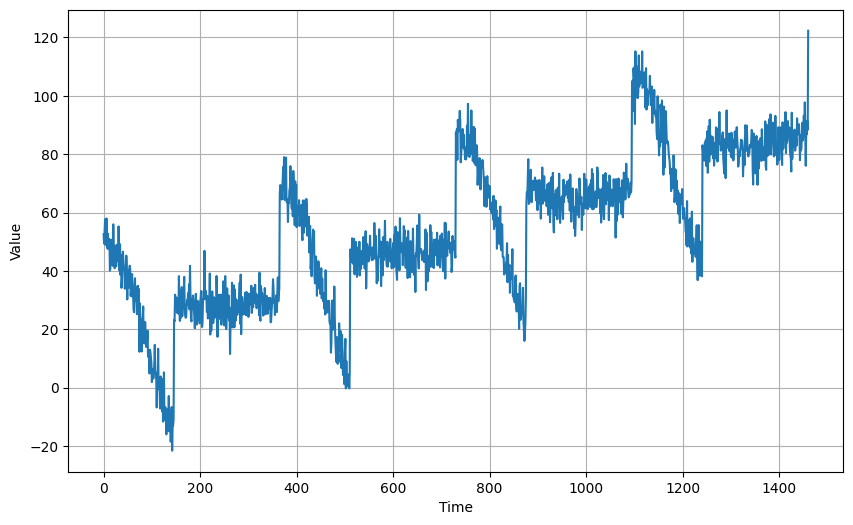

In [9]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [10]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [11]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [13]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

You will use three dense layers in this exercise as shown below. As expected, the number of trainable parameters will increase and the model summary shows that it is more than tenfold of the previous lab.

In [14]:
# Build the model
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# Print the model summary
model_baseline.summary()

/Users/civye1/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331 (1.29 KB)

 Trainable params: 331 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

You will then compile and train the model using the same settings as before. Observe how the loss is decreasing because you will revisit it later in this lab.

In [15]:
# Set the training parameters
model_baseline.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [16]:
# Train the model
model_baseline.fit(dataset,epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 1688.6841
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - loss: 155.3801
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step - loss: 133.8202
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - loss: 120.0412
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - loss: 101.6013
Epoch 6/100


2024-07-07 17:33:24.329995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/civye1/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-07 17:33:24.389738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:24.432215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:24.475517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step - loss: 88.5063
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - loss: 92.0582
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step - loss: 95.3874
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - loss: 71.2793
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step - loss: 67.6210
Epoch 11/100


2024-07-07 17:33:24.560671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:24.602761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:24.645146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:24.686875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:24.729380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step - loss: 70.7633
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step - loss: 74.1119
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step - loss: 69.7211
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 65.3844
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step - loss: 67.6341
Epoch 16/100


2024-07-07 17:33:24.771461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:24.814002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:24.855964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:24.896886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:24.939368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step - loss: 54.1456
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step - loss: 53.3289
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step - loss: 55.0023
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - loss: 51.0313
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - loss: 57.9720
Epoch 21/100


2024-07-07 17:33:24.981923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:25.022906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:25.064761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:25.107225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:25.149612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step - loss: 58.6998
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step - loss: 57.8677
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 56.1383
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - loss: 55.4940
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - loss: 57.1659
Epoch 26/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 31.4926

2024-07-07 17:33:25.191042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:25.233277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:25.273428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:25.313182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:25.352989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - loss: 48.9336
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - loss: 56.2187
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - loss: 51.8734
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - loss: 50.0840
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - loss: 48.9173
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step - loss: 55.1201
Epoch 32/100


2024-07-07 17:33:25.392653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:25.431424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:25.471046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:25.510727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:25.549618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:25.588255: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - loss: 45.5633
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - loss: 55.7264
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - loss: 55.2393
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 49.1627
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step - loss: 49.8551
Epoch 37/100


2024-07-07 17:33:25.626788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:25.666187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:25.705599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:25.744722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:25.806840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step - loss: 51.3674
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - loss: 52.1744
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 49.9790
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - loss: 48.1915
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - loss: 53.3356
Epoch 42/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 90.5710

2024-07-07 17:33:25.848122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:25.889572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:25.929753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:25.970115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:26.009531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:26.048965: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 57.4649
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - loss: 44.4761
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step - loss: 53.1513
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - loss: 49.4978
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - loss: 45.6681
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - loss: 49.7368
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - loss: 50.1987
Epoch 49/100


2024-07-07 17:33:26.088607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:26.128476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:26.167196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:26.205972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:26.245561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:26.284855: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - loss: 45.6913
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step - loss: 51.8582
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 50.8897
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - loss: 54.6848
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - loss: 45.9860
Epoch 54/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 29.6749

2024-07-07 17:33:26.326147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:26.367598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:26.407402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:26.446212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:26.486939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - loss: 46.1414
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - loss: 54.1120
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 48.7025
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - loss: 44.3185
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - loss: 44.6114
Epoch 59/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - loss: 47.2430
Epoch 60/100


2024-07-07 17:33:26.527734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:26.567696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:26.608157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:26.648502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:26.687518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:26.727347: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - loss: 42.4293
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - loss: 46.9814
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step - loss: 58.2332
Epoch 63/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - loss: 52.7485
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - loss: 45.8783
Epoch 65/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - loss: 44.7364
Epoch 66/100


2024-07-07 17:33:26.766861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:26.806140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:26.845722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:26.884900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:26.923117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:26.962999: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - loss: 50.8384
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - loss: 44.2517
Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step - loss: 44.1124
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step - loss: 49.4853
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step - loss: 47.8733
Epoch 71/100


2024-07-07 17:33:27.002316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:27.041620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:27.101662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:27.143102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:27.184675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - loss: 44.0887
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step - loss: 46.5888
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 47.9531
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - loss: 42.7255
Epoch 75/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - loss: 46.4545
Epoch 76/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 49.6679
Epoch 77/100


2024-07-07 17:33:27.225440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:27.265495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:27.305824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:27.345632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:27.385186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:27.424205: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 49.2423
Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - loss: 43.9410
Epoch 79/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - loss: 43.5576
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - loss: 47.2510
Epoch 81/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 41.5304
Epoch 82/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 53.8973
Epoch 83/100


2024-07-07 17:33:27.463163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:27.502527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:27.542427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:27.580616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:27.620453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:27.658456: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - loss: 44.9398
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step - loss: 43.0143
Epoch 85/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - loss: 51.4616
Epoch 86/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - loss: 45.6533
Epoch 87/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 43.1043
Epoch 88/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 32.3424

2024-07-07 17:33:27.700291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:27.743435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:27.784202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:27.824369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:27.864077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step - loss: 44.9486
Epoch 89/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - loss: 44.9557
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - loss: 45.0095
Epoch 91/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - loss: 49.4695
Epoch 92/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - loss: 41.7975
Epoch 93/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - loss: 40.9802
Epoch 94/100


2024-07-07 17:33:27.905560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:27.945035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:27.984771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:28.024303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:28.062956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:28.101512: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 48.8324
Epoch 95/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - loss: 47.7597
Epoch 96/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 46.5813
Epoch 97/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step - loss: 48.0927
Epoch 98/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - loss: 42.4320
Epoch 99/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - loss: 43.8342


2024-07-07 17:33:28.141710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:28.182269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:28.224370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:28.263847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:28.303510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:33:28.341532: W tensorflow/core/framework/local_rendezvous.cc:404]

Epoch 100/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 51.0049


2024-07-07 17:33:28.378118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


You can then get some predictions and visualize it as before. Since the network is deeper, the predictions might go slower so you may want to minimize unnecessary computations. 

In the previous lab, you might remember the model generating predictions using the entire `series` data. That resulted in 1,441 points in the `forecast` list then you sliced the 461 points that aligns with the validation set using `forecast = forecast[split_time - window_size:]`. 

You can make this process faster by just generating 461 points right from the start. That way, you don't waste time predicting points that will just be thrown away later. The code below will do just that. It will just get the points needed from the original `series` before calling the `predict()` method. With that, all predictions will align with the validation set already and the for-loop will run for only 461 times instead of 1,441. 

In the next lab, you'll see an even faster way to generate these predictions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


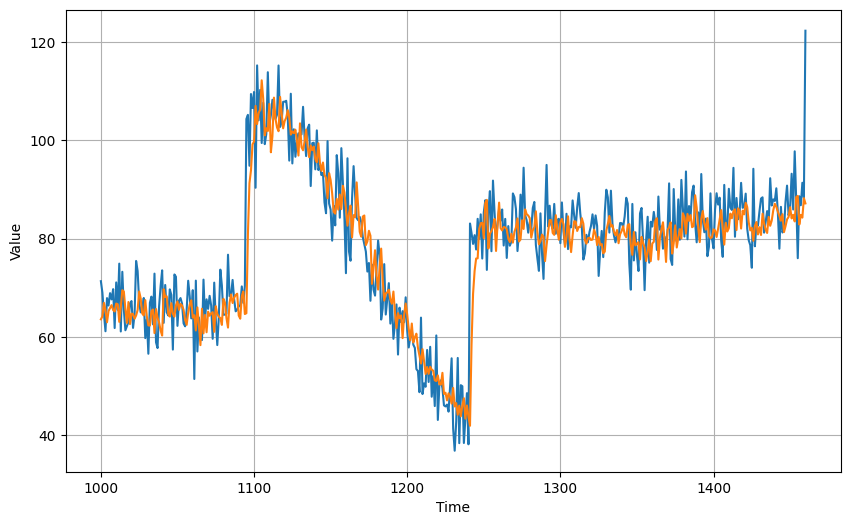

In [17]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_baseline.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then get the MSE and MAE for reference.

In [18]:
# Compute the metrics
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

46.68708
5.0091305


## Tune the learning rate

You saw that the training went well with the initial learning rate that you chose (i.e. `1e-6`). However, you're not yet sure if it is the best setting for this particular model. It might seem inconsequential in this simple model but when you have more complex ones, spending some time to tune the learning rate can lead to better training results. You will see how to do that in this section.

First, you will build the same model architecture you just used.

In [19]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

Next, you will declare a [learning rate scheduler](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) callback. This will allow you to dynamically set the learning rate based on the epoch number during training. As shown below, you will pass a lambda function to declare the value of the learning rate. It will start at `1e-8` at epoch 0 and is scaled by `10**(epoch / 20)` as the training goes on.

In [20]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

You will then compile the model. Just to note a subtle difference with the lecture video, you don't have to set the `learning_rate` argument of the optimizer here before compiling. You can just leave the default (i.e. [`0.01` for SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD#args)) and allow the learning rate scheduler to set it dynamically.

In [21]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

You will pass in the `lr_schedule` callback in the `callbacks` parameter of the [`fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method. As you run the training below, you will see the learning rate at a particular epoch denoted by `lr` in the console output. Notice that it is increasing as expected based on the lambda function you used.

In [22]:
# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1653.9115 - learning_rate: 1.0000e-08
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - loss: 1561.0437 - learning_rate: 1.1220e-08
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step - loss: 1403.3060 - learning_rate: 1.2589e-08
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - loss: 1333.4554 - learning_rate: 1.4125e-08
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - loss: 1173.4985 - learning_rate: 1.5849e-08
Epoch 6/100


2024-07-07 17:53:17.036277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:17.098299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:17.141258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:17.185368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:17.228784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step - loss: 1047.9929 - learning_rate: 1.7783e-08
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - loss: 815.7847 - learning_rate: 1.9953e-08
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - loss: 694.4271 - learning_rate: 2.2387e-08
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - loss: 523.9905 - learning_rate: 2.5119e-08
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - loss: 427.8200 - learning_rate: 2.8184e-08
Epoch 11/100


2024-07-07 17:53:17.272523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:17.315148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:17.358489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:17.401781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:17.444435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step - loss: 346.5911 - learning_rate: 3.1623e-08
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step - loss: 282.5902 - learning_rate: 3.5481e-08
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step - loss: 223.0154 - learning_rate: 3.9811e-08
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 185.2193 - learning_rate: 4.4668e-08
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - loss: 184.4566 - learning_rate: 5.0119e-08
Epoch 16/100


2024-07-07 17:53:17.486853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:17.528898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:17.571165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:17.612110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:17.654052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - loss: 174.5875 - learning_rate: 5.6234e-08
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step - loss: 199.4111 - learning_rate: 6.3096e-08
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - loss: 165.2960 - learning_rate: 7.0795e-08
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - loss: 181.3822 - learning_rate: 7.9433e-08
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - loss: 170.9753 - learning_rate: 8.9125e-08
Epoch 21/100


2024-07-07 17:53:17.721756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:17.765123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:17.807712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:17.850478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:17.895412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - loss: 165.5107 - learning_rate: 1.0000e-07
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step - loss: 176.0678 - learning_rate: 1.1220e-07
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step - loss: 162.6064 - learning_rate: 1.2589e-07
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - loss: 164.3973 - learning_rate: 1.4125e-07
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - loss: 173.2946 - learning_rate: 1.5849e-07
Epoch 26/100


2024-07-07 17:53:17.940067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:17.982053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:18.027311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:18.072253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:18.115941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - loss: 155.0810 - learning_rate: 1.7783e-07
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step - loss: 149.3617 - learning_rate: 1.9953e-07
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 158.0232 - learning_rate: 2.2387e-07
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step - loss: 132.2516 - learning_rate: 2.5119e-07
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 152.1514 - learning_rate: 2.8184e-07
Epoch 31/100


2024-07-07 17:53:18.158560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:18.200555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:18.242166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:18.284847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:18.325058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - loss: 136.4690 - learning_rate: 3.1623e-07
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - loss: 139.3991 - learning_rate: 3.5481e-07
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - loss: 123.2342 - learning_rate: 3.9811e-07
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step - loss: 126.9541 - learning_rate: 4.4668e-07
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - loss: 128.4857 - learning_rate: 5.0119e-07
Epoch 36/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 185.8440

2024-07-07 17:53:18.367058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:18.408485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:18.449420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:18.489920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:18.531216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - loss: 118.2864 - learning_rate: 5.6234e-07
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 100.5932 - learning_rate: 6.3096e-07
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step - loss: 98.3976 - learning_rate: 7.0795e-07
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step - loss: 87.0322 - learning_rate: 7.9433e-07
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 101.9212 - learning_rate: 8.9125e-07
Epoch 41/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 39.4326

2024-07-07 17:53:18.573214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:18.615455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:18.655610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:18.696433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:18.736768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step - loss: 69.5888 - learning_rate: 1.0000e-06
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step - loss: 78.3955 - learning_rate: 1.1220e-06
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - loss: 68.4041 - learning_rate: 1.2589e-06
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - loss: 64.6499 - learning_rate: 1.4125e-06
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - loss: 54.1629 - learning_rate: 1.5849e-06
Epoch 46/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 118.2692

2024-07-07 17:53:18.778481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:18.820872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:18.862017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:18.902811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:18.944563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - loss: 67.0326 - learning_rate: 1.7783e-06
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - loss: 56.0793 - learning_rate: 1.9953e-06
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - loss: 55.2182 - learning_rate: 2.2387e-06
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - loss: 58.2846 - learning_rate: 2.5119e-06
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - loss: 54.3049 - learning_rate: 2.8184e-06
Epoch 51/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 70.6871

2024-07-07 17:53:18.986559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:19.028572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:19.069540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:19.110089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:19.150823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - loss: 59.2821 - learning_rate: 3.1623e-06
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step - loss: 58.9764 - learning_rate: 3.5481e-06
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 62.3088 - learning_rate: 3.9811e-06
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - loss: 53.5876 - learning_rate: 4.4668e-06
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step - loss: 47.6585 - learning_rate: 5.0119e-06
Epoch 56/100


2024-07-07 17:53:19.192190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:19.233608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:19.284562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:19.342380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:19.383567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - loss: 55.0805 - learning_rate: 5.6234e-06
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step - loss: 49.8954 - learning_rate: 6.3096e-06
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - loss: 58.4518 - learning_rate: 7.0795e-06
Epoch 59/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step - loss: 49.9558 - learning_rate: 7.9433e-06
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - loss: 45.0410 - learning_rate: 8.9125e-06
Epoch 61/100


2024-07-07 17:53:19.426269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:19.468122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:19.509474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:19.550838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:19.592353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step - loss: 46.1135 - learning_rate: 1.0000e-05
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - loss: 48.4307 - learning_rate: 1.1220e-05
Epoch 63/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - loss: 50.4177 - learning_rate: 1.2589e-05
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - loss: 44.0256 - learning_rate: 1.4125e-05
Epoch 65/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 49.0698 - learning_rate: 1.5849e-05
Epoch 66/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 58.2328

2024-07-07 17:53:19.634159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:19.675858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:19.716063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:19.756683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:19.796625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step - loss: 53.9603 - learning_rate: 1.7783e-05
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - loss: 61.2310 - learning_rate: 1.9953e-05
Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step - loss: 45.2406 - learning_rate: 2.2387e-05
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step - loss: 55.1788 - learning_rate: 2.5119e-05
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step - loss: 46.5810 - learning_rate: 2.8184e-05
Epoch 71/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 29.3152

2024-07-07 17:53:19.837395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:19.876973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:19.917369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:19.957741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:19.998693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step - loss: 47.9847 - learning_rate: 3.1623e-05
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step - loss: 92.4212 - learning_rate: 3.5481e-05
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - loss: 75.5971 - learning_rate: 3.9811e-05
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - loss: 72.0160 - learning_rate: 4.4668e-05
Epoch 75/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 47.5602 - learning_rate: 5.0119e-05
Epoch 76/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 38.9784

2024-07-07 17:53:20.040345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:20.082570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:20.123321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:20.165051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:20.205222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - loss: 61.7465 - learning_rate: 5.6234e-05
Epoch 77/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - loss: 98.3577 - learning_rate: 6.3096e-05
Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - loss: 163.9176 - learning_rate: 7.0795e-05
Epoch 79/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - loss: 2729.6387 - learning_rate: 7.9433e-05
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - loss: 2103.6829 - learning_rate: 8.9125e-05
Epoch 81/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2010.4958

2024-07-07 17:53:20.245843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:20.286120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:20.326092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:20.367651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:20.409149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - loss: 1969.0853 - learning_rate: 1.0000e-04
Epoch 82/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - loss: 1685.4988 - learning_rate: 1.1220e-04
Epoch 83/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 1530.1372 - learning_rate: 1.2589e-04
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - loss: 1471.2029 - learning_rate: 1.4125e-04
Epoch 85/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 1204.4519 - learning_rate: 1.5849e-04
Epoch 86/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1204.9082

2024-07-07 17:53:20.451108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:20.492268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:20.533704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:20.575095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:20.616495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step - loss: 1133.0010 - learning_rate: 1.7783e-04
Epoch 87/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step - loss: 933.0594 - learning_rate: 1.9953e-04
Epoch 88/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - loss: 847.7939 - learning_rate: 2.2387e-04
Epoch 89/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step - loss: 780.7551 - learning_rate: 2.5119e-04
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step - loss: 682.0095 - learning_rate: 2.8184e-04
Epoch 91/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 511.2931

2024-07-07 17:53:20.656756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:20.698398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:20.739241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:20.779861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:20.820132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 571.1031 - learning_rate: 3.1623e-04
Epoch 92/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - loss: 525.6404 - learning_rate: 3.5481e-04
Epoch 93/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - loss: 483.1460 - learning_rate: 3.9811e-04
Epoch 94/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step - loss: 464.5811 - learning_rate: 4.4668e-04
Epoch 95/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - loss: 407.8574 - learning_rate: 5.0119e-04
Epoch 96/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 457.5629

2024-07-07 17:53:20.860696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:20.902155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:20.942400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:20.982909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:21.023813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - loss: 441.6775 - learning_rate: 5.6234e-04
Epoch 97/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - loss: 427.3006 - learning_rate: 6.3096e-04
Epoch 98/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - loss: 443.4336 - learning_rate: 7.0795e-04
Epoch 99/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - loss: 411.7770 - learning_rate: 7.9433e-04
Epoch 100/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - loss: 420.7227 - learning_rate: 8.9125e-04


2024-07-07 17:53:21.066185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:21.106329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:21.146906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:21.187490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 17:53:21.229344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Next step is to plot the results of the training. You will visualize the loss at each value of the learning rate.

(1e-08, 0.001, 0.0, 300.0)

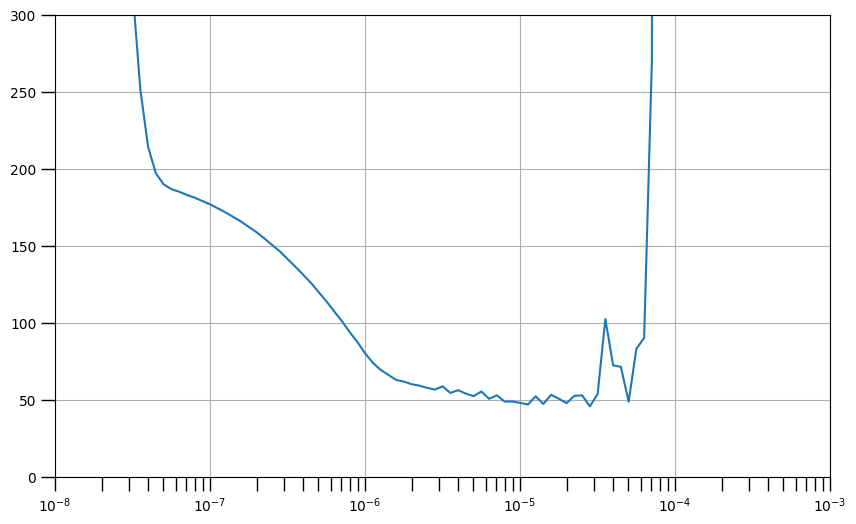

In [27]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 300])

The generated graph above shows the values of the range of learning rates that leads to lower losses (i.e. sloping downward) and also which ones cause the training to become unstable (i.e. jagged edges and pointing upwards). In general, you will want to pick a point in a downward slope. That means the network is still learning at that point and is stable. Choosing close to the minimum point of the graph will make the training converge to that loss value quicker, as will be shown in the next cells.

First, you will initialize the same model architecture again.

In [28]:
# Build the model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

You will then set the optimizer with a learning rate close to the minimum. It is set to `4e-6` initially but feel free to change based on your results.

In [29]:
# Set the optimizer with the tuned learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=4e-6, momentum=0.9)

You can then compile and train the model as before. Observe the loss values and compare it to the output of the baseline model you had before. Most likely, you will have met the final loss value of the `model_baseline` within the first 50 epochs of training this `model_tune`. You will also likely have a lower loss after all 100 epochs are done.

In [30]:
# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - loss: 842.8193
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 86.4664
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - loss: 73.2272
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step - loss: 56.9894
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - loss: 63.7665
Epoch 6/100


2024-07-07 18:07:05.804309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:05.853779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:05.896959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:05.939578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:05.981999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - loss: 55.0669
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step - loss: 50.9249
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step - loss: 62.4836
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 48.6679
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - loss: 50.0724
Epoch 11/100


2024-07-07 18:07:06.024067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:06.065026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:06.107599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:06.147744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:06.191155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step - loss: 49.9092
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step - loss: 48.0242
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 48.6023
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step - loss: 44.7505
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - loss: 48.5262
Epoch 16/100


2024-07-07 18:07:06.233700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:06.275643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:06.318134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:06.360580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:06.431159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step - loss: 54.8357
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - loss: 49.4239
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step - loss: 43.2465
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - loss: 45.2610
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step - loss: 43.2423
Epoch 21/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 34.4441

2024-07-07 18:07:06.474557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:06.517084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:06.558324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:06.599820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:06.639999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step - loss: 42.9206
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - loss: 40.5933
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 252us/step - loss: 45.8530
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - loss: 45.0544
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - loss: 42.3662
Epoch 26/100


2024-07-07 18:07:06.681702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:06.725559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:06.768571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:06.809355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:06.850360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step - loss: 43.5110
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step - loss: 48.8515
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - loss: 39.1202
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - loss: 46.7865
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step - loss: 40.8719
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step - loss: 46.4935


2024-07-07 18:07:06.890584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:06.930875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:06.970854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:07.010184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:07.050628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:07.090378: W tensorflow/core/framework/local_rendezvous.cc:404]

Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - loss: 46.4478
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 42.2364
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - loss: 44.0340
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 42.8638
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - loss: 41.5876
Epoch 37/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 31.7998

2024-07-07 18:07:07.130208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:07.171340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:07.212783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:07.252501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:07.292819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - loss: 40.0436
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - loss: 44.9288
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step - loss: 46.5085
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step - loss: 39.7030
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - loss: 46.6326
Epoch 42/100


2024-07-07 18:07:07.333223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:07.373086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:07.412995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:07.457848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:07.499110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step - loss: 40.4853
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step - loss: 43.1629
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 38.8976
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step - loss: 42.1341
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - loss: 46.2528
Epoch 47/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 79.9306

2024-07-07 18:07:07.542516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:07.583867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:07.624310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:07.664956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:07.705096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step - loss: 43.7293
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step - loss: 42.4632
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step - loss: 42.7708
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step - loss: 39.9653
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - loss: 42.4201
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 39.0683


2024-07-07 18:07:07.745287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:07.785576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:07.825279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:07.865199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:07.904976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:07.945069: W tensorflow/core/framework/local_rendezvous.cc:404]

Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step - loss: 49.4193
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 41.0961
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - loss: 53.4733
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step - loss: 34.0715
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - loss: 39.1855
Epoch 58/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 51.3368

2024-07-07 18:07:07.989645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:08.031968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:08.072555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:08.113025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:08.154821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 41.4412
Epoch 59/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - loss: 45.1543
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step - loss: 42.0711
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step - loss: 41.6158
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - loss: 44.5282
Epoch 63/100


2024-07-07 18:07:08.195921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:08.262208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:08.304635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:08.346007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:08.387071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - loss: 40.4078
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - loss: 41.4290
Epoch 65/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step - loss: 45.0543
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step - loss: 36.2546
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step - loss: 34.7818
Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step - loss: 41.1597
Epoch 69/100


2024-07-07 18:07:08.426989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:08.467143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:08.506868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:08.546702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:08.586816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:08.626217: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step - loss: 45.8231
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step - loss: 38.8558
Epoch 71/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - loss: 37.6206
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step - loss: 41.8190
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - loss: 43.1113
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step - loss: 40.3073
Epoch 75/100


2024-07-07 18:07:08.666038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:08.706169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:08.745927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:08.785897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:08.825486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:08.865420: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step - loss: 42.7517
Epoch 76/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step - loss: 40.5827
Epoch 77/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step - loss: 38.7713
Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - loss: 46.1913
Epoch 79/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - loss: 36.4836
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - loss: 38.8289


2024-07-07 18:07:08.905184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:08.945189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:08.985370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:09.025691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:09.064151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:09.104865: W tensorflow/core/framework/local_rendezvous.cc:404]

Epoch 81/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 41.2986
Epoch 82/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - loss: 50.9433
Epoch 83/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - loss: 38.4466
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step - loss: 36.3013
Epoch 85/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step - loss: 34.5140
Epoch 86/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - loss: 37.6448
Epoch 87/100


2024-07-07 18:07:09.145785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:09.186307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:09.225586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:09.265611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:09.305472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:09.344818: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - loss: 36.2820
Epoch 88/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - loss: 43.6850
Epoch 89/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step - loss: 36.0266
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - loss: 37.5525
Epoch 91/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - loss: 41.1609
Epoch 92/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 95.3494

2024-07-07 18:07:09.386153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:09.426792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:09.467056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:09.507147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:09.547315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:09.587134: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step - loss: 45.2757
Epoch 93/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - loss: 40.3266
Epoch 94/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - loss: 47.7036
Epoch 95/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step - loss: 39.6888
Epoch 96/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - loss: 36.4703
Epoch 97/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step - loss: 38.2329
Epoch 98/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step - loss: 44.9541
Epoch 99/100


2024-07-07 18:07:09.627761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:09.668315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:09.708258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:09.748138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:09.787916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:09.826920: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - loss: 40.4845
Epoch 100/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step - loss: 38.7171


2024-07-07 18:07:09.867247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-07 18:07:09.908227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


You can plot the `loss` values by getting it from the [History](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) object returned by the `fit()` method. As you can see, the model is still trending downward after the training.

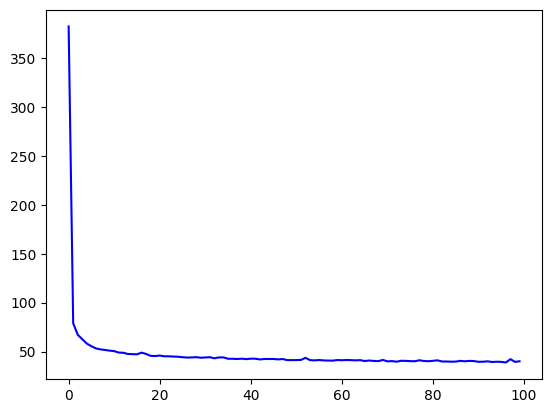

In [31]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

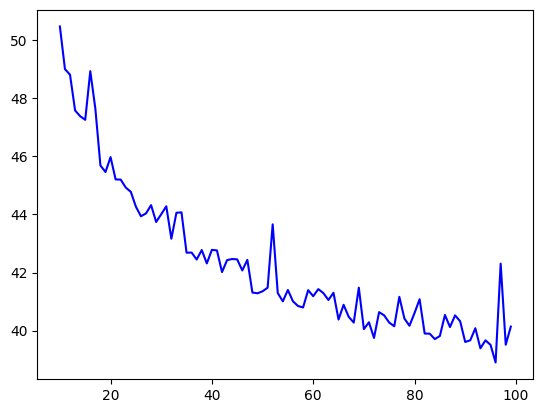

In [32]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

You can get the predictions again and overlay it on the validation set.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


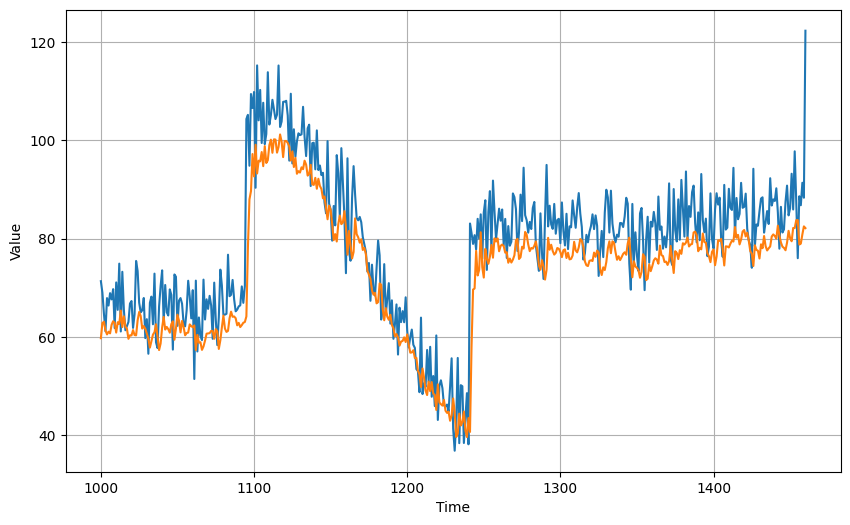

In [33]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_tune.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

Finally, you can compute the metrics and you should arrive at similar figures compared to the baseline. If it is much worse, then the model might have overfitted and you can use techniques you know to avoid it (e.g. adding dropout).

In [34]:
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

72.42469
6.535023


## Wrap Up

This concludes the exercise on using a deep neural network for forecasting. Along the way, you did some hyperparameter tuning, particularly on the learning rate. You will be using this technique as well in the next labs. Next week, you will be using recurrent neural networks to build your forecasting model. See you there and keep it up!